In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import torch


In [ ]:
ls

cvar_planning.ipynb  model_improvement.ipynb  rl.ipynb
downsample.ipynb     model_vis.ipynb          uq_10min1hr_50samples.npy
explore.ipynb        planning.ipynb           workspace.ipynb


## Down sampling

In [1]:
# 10s per sample -> 5 minutes per sample

downsampled = []


for i in range(5):
    with open('/abiomed-tmp/intermediate/at_data_amicgs_{}.pkl'.format(i), 'rb') as f:
        data_amicgs = pickle.load(f)
    
    for j in range(len(data_amicgs)):
        struct = data_amicgs[j]
        id = struct['patient_id']
        data = struct['data']
        # Downsample by taking the average of every 30 samples
        if len(data) >= 30:
            # Reshape to group every 30 samples and take mean
            num_complete_groups = len(data) // 30
            reshaped_data = data[:num_complete_groups * 30].reshape(num_complete_groups, 30, -1)
            downsampled_data = reshaped_data.mean(axis=1)
            downsampled.append({
                'patient_id': id,
                'data': downsampled_data
            })
    
# # Save downsampled data as pickle
# with open('/abiomed-tmp/intermediate/at_5min_data.pkl', 'wb') as f:
#     pickle.dump(downsampled, f)

# print(f"Saved {len(downsampled)} downsampled patient records")



FileNotFoundError: [Errno 2] No such file or directory: '/abiomed-tmp/intermediate/at_data_amicgs_0.pkl'

In [24]:
# 10s -> 10 minutes per sample

downsampled = []


for i in range(5):
    with open('/abiomed-tmp/intermediate/at_data_amicgs_{}.pkl'.format(i), 'rb') as f:
        data_amicgs = pickle.load(f)
    
    for j in range(len(data_amicgs)):
        struct = data_amicgs[j]
        id = struct['patient_id']
        data = struct['data']
        # Downsample by taking the average of every 60 samples
        if len(data) >= 60:
            # Reshape to group every 30 samples and take mean
            num_complete_groups = len(data) // 60
            reshaped_data = data[:num_complete_groups * 60].reshape(num_complete_groups, 60, -1)
            downsampled_data = reshaped_data.mean(axis=1)
            downsampled.append({
                'patient_id': id,
                'data': downsampled_data
            })
    
# # Save downsampled data as pickle
# with open('/abiomed-tmp/intermediate/at_10min_data.pkl', 'wb') as f:
#     pickle.dump(downsampled, f)

# print(f"Saved {len(downsampled)} downsampled patient records")

Saved 1325 downsampled patient records


In [5]:
downsampled = []


for i in range(5):
    with open('/abiomed/intermediate/low_score_amicgs/at_data_amicgs_{}.pkl'.format(i), 'rb') as f:
        data_amicgs = pickle.load(f)
    
    for j in range(len(data_amicgs)):
        struct = data_amicgs[j]
        id = struct['patient_id']
        data = struct['data']
        # Downsample by taking the average of every 60 samples
        if len(data) >= 60:
            # Reshape to group every 30 samples and take mean
            num_complete_groups = len(data) // 60
            reshaped_data = data[:num_complete_groups * 60].reshape(num_complete_groups, 60, -1)
            downsampled_data = reshaped_data.mean(axis=1)
            downsampled.append({
                'patient_id': id,
                'data': downsampled_data
            })

In [6]:
    
# Save downsampled data as pickle
with open('/abiomed/intermediate/low_score_amicgs/at_10min_data.pkl', 'wb') as f:
    pickle.dump(downsampled, f)

print(f"Saved {len(downsampled)} downsampled patient records")

Saved 436 downsampled patient records


# Windowing

In [9]:


def create_windows(data, window_size, stride):
    Xs = []

    if len(data) > window_size:  
        # Only create windows if we have enough data points
        i = 0
        while i < len(data) - window_size:
            Xs.append(data[i:i+window_size])
            i += stride
        Xs = torch.stack(Xs)
    return Xs

In [4]:


with open('/abiomed/intermediate/at_10min_data.pkl', 'rb') as f:
    downsampled = pickle.load(f)

print("Normal data 10min", len(downsampled), downsampled[0]['data'].shape)
#80% for training, 20% for testing
train_downsampled = downsampled[:int(len(downsampled) * 0.8)]
test_downsampled = downsampled[int(len(downsampled) * 0.8):]



with open('/abiomed/intermediate/low_score_amicgs/at_10min_data.pkl', 'rb') as f:
    downsampled_ll = pickle.load(f)

print("low score 10min", len(downsampled_ll), downsampled[0]['data'].shape)
#80% for training, 20% for testing
train_downsampled = downsampled[:int(len(downsampled_ll) * 0.8)]
test_downsampled = downsampled[int(len(downsampled_ll) * 0.8):]


Normal data 10min 1325 torch.Size([4, 13])
low score 10min 436 torch.Size([4, 13])


In [13]:
1325+436

1761

In [15]:
34/6

5.666666666666667

35.97160704145372
72.3564453573706


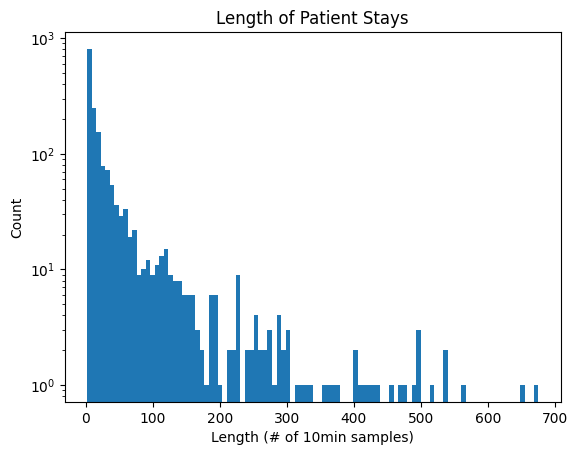

In [12]:
import matplotlib.pyplot as plt

lengths = []
for a in downsampled+downsampled_ll:
    lengths.append(len(a['data']))

print(np.mean(lengths))
print(np.std(lengths))

# log scale
plt.hist(lengths, bins=100, log=True)
plt.title("Length of Patient Stays")
plt.xlabel("Length (# of 10min samples)")
plt.ylabel("Count")
plt.show()









In [14]:
np.sum(np.array(lengths) > 6)

np.int64(1085)

In [ ]:


with open('/abiomed/intermediate/at_10min_data.pkl', 'rb') as f:
    downsampled = pickle.load(f)

print("Normal data 10min", len(downsampled) , "samples", downsampled[0]['data'].shape)
#75% for training, 25% for testing + validation
train_downsampled_normal = downsampled[:int(len(downsampled) * 0.8)]
test_downsampled_normal = downsampled[int(len(downsampled) * 0.8):]


with open('/abiomed/intermediate/low_score_amicgs/at_10min_data.pkl', 'rb') as f:
    downsampled = pickle.load(f)

print("low score 10min", len(downsampled), "samples", downsampled[0]['data'].shape)
#75% for training, 25% for testing + validation
train_downsampled_low_score = downsampled[:int(len(downsampled) * 0.8)]
test_downsampled_low_score = downsampled[int(len(downsampled) * 0.8):]


train_all = train_downsampled_normal + train_downsampled_low_score
test_all = test_downsampled_normal + test_downsampled_low_score




Normal data 10min 1325 samples torch.Size([4, 13])
low score 10min 436 samples torch.Size([50, 13])


In [24]:

train_1hr = []
test_1hr = []

window_size = 12
stride = 3

for struct in train_all:  
    data = struct['data']
    xs = create_windows(data,window_size,stride)
    if len(xs) > 4: # more than 4 hours in length
        train_1hr.append(xs)

for struct in test_all:
    data = struct['data']
    xs = create_windows(data,window_size,stride)
    if len(xs) > 4: # more than 4 hours in length
        test_1hr.append(xs)

train_1hr = torch.cat(train_1hr)
test_1hr = torch.cat(test_1hr)

print("train_1hr.shape",train_1hr.shape)
print("test_1hr.shape",test_1hr.shape)

mean = torch.mean(train_1hr.reshape(-1, 13), axis=0)
std = torch.std(train_1hr.reshape(-1, 13), axis=0)

# randomly sample half of the test data for validation
val_data = test_1hr[torch.randperm(test_1hr.shape[0])[:len(test_1hr)//2]]

#dict_keys(['train', 'val', 'test', 'mean', 'std'])

with open('/abiomed/downsampled/10min_1hr_all_data.pkl', 'wb') as f:
    pickle.dump({'train': train_1hr, 'val': val_data, 'test': test_1hr, 'mean': mean, 'std': std}, f)

train_1hr.shape torch.Size([12051, 12, 13])
test_1hr.shape torch.Size([3876, 12, 13])


In [23]:
print(mean.shape)

torch.Size([13])


In [24]:
12051+3876

15927

# Average Doctor's reward

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
# add parent directory to path
sys.path.append("..")
from reward_func import compute_reward_smooth


with open('/abiomed/downsampled/10min_1hr_all_data.pkl', 'rb') as f:
    data = pickle.load(f)


In [3]:
# check if has nan

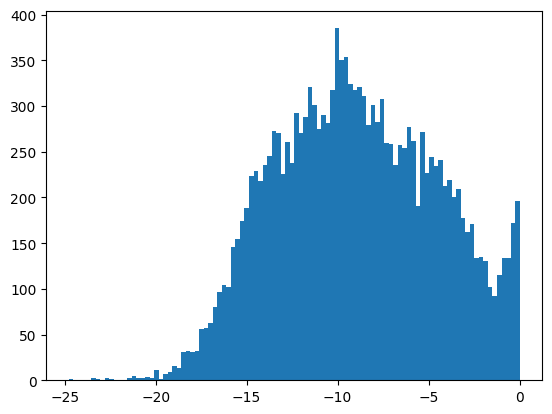

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
# add parent directory to path
sys.path.append("..")
from reward_func import compute_reward_smooth



with open('/abiomed/downsampled/10min_1hr_all_data.pkl', 'rb') as f:
    data = pickle.load(f)

data_train = data['train']
data_test = data['test']


together = torch.cat([data_train, data_test])

rewards = []
for i in range(len(together)):
    data_o = together[i][6:]
    reward = compute_reward_smooth(data_o)
    rewards.append(reward)

rewards = np.array(rewards)
plt.hist(rewards, bins=100)
plt.show()



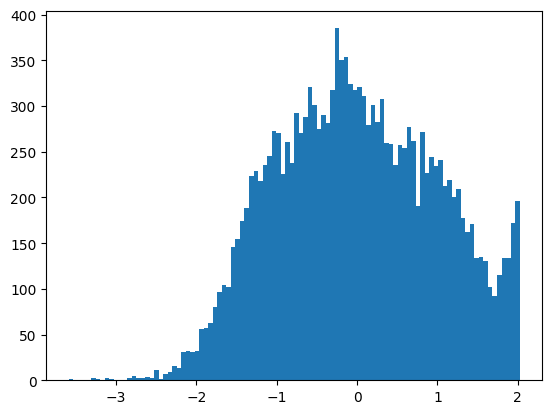

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
# add parent directory to path
sys.path.append("..")
from reward_func import compute_reward_smooth



with open('/abiomed/downsampled/10min_1hr_all_data.pkl', 'rb') as f:
    data = pickle.load(f)

data_train = data['train']
data_test = data['test']
together = torch.cat([data_train, data_test])

rewards = []
for i in range(len(together)):
    data_o = together[i][6:]
    reward = (compute_reward_smooth(data_o)+ 8.929224) / 4.4131603
    rewards.append(reward)

rewards = np.array(rewards)
plt.hist(rewards, bins=100)
plt.show()




In [4]:
np.mean(rewards)

np.float32(1.7819644e-07)

In [6]:

def calculate_trend(map_values: torch.Tensor) -> torch.Tensor:
    """Calculate trend classification for MAP values.
    
    Args:
        map_values: MAP values of shape [batch, time_steps]
        
    Returns:
        trends: Trend classification (0=down, 1=flat, 2=up) of shape [batch]
    """
    # Calculate slope over time steps
    time_steps = torch.arange(map_values.shape[1], dtype=torch.float32)
    
    # For each sample, calculate linear regression slope
    slopes = []
    for i in range(map_values.shape[0]):
        y = map_values[i]
        # Simple slope calculation: (y_end - y_start) / (t_end - t_start)
        slope = (y[-1] - y[0]) / (time_steps[-1] - time_steps[0])
        slopes.append(slope)
    
    slopes = torch.tensor(slopes)
    
    # Classify trends
    trends = torch.ones_like(slopes, dtype=torch.long)  # Default to flat (1)
    trends[slopes > 1.0] = 2  # Up
    trends[slopes < -1.0] = 0  # Down
    
    return trends

In [8]:
target_trends

tensor([0, 2, 0,  ..., 0, 2, 1])

In [14]:
def analyze_trends(data):
    map_pred = data[:, 6:, 0]  # [batch, forecast_horizon]
    target_trends = calculate_trend(map_pred)
    # Find indices where target trend is 0 (downward trend)
    down_trend_indices = torch.where(target_trends == 0)[0]
    print(f"Number of samples with downward trend: {len(down_trend_indices)}")

    # Find indices where target trend is 1 (flat trend)
    flat_trend_indices = torch.where(target_trends == 1)[0]
    print(f"Number of samples with flat trend: {len(flat_trend_indices)}")

    # Find indices where target trend is 2 (upward trend)
    up_trend_indices = torch.where(target_trends == 2)[0]
    print(f"Number of samples with upward trend: {len(up_trend_indices)}")

    # Subsample the data where target trend is 1
    percentage_flat = (len(flat_trend_indices) / len(target_trends))

    # Calculate percentage of flat trend samples
    print(f"Percentage of samples with flat trend: {percentage_flat:.2f}%")
    subsample_rate = (1-percentage_flat)/(percentage_flat)
    print("subsample_rate", subsample_rate)
    # randomly sample from the flat trend indices
    flat_trend_indices = flat_trend_indices[torch.randperm(len(flat_trend_indices))[:int(subsample_rate * len(flat_trend_indices))]]

    data_train_flat_trend = data[flat_trend_indices]
    print(f"Shape of subsampled data: {data_train_flat_trend.shape}")

    # Optional: visualize the first few flat trend samples
    if len(flat_trend_indices) > 0:
        plt.figure(figsize=(10, 6))
        for i in range(min(5, len(flat_trend_indices))):
            plt.plot(data_train_flat_trend[i, 6:, 0].numpy(), label=f"Sample {i+1}")
        plt.title("Examples of MAP values with flat trend")
        plt.xlabel("Time steps")
        plt.ylabel("MAP value")
        plt.legend()
        plt.show()

    all_data = torch.cat([data_train_flat_trend, 
                            data[down_trend_indices], 
                            data[up_trend_indices]])

    return all_data

Number of samples with downward trend: 1886
Number of samples with flat trend: 8486
Number of samples with upward trend: 1679
Percentage of samples with flat trend: 0.70%
subsample_rate 0.420103700212114
Shape of subsampled data: torch.Size([3564, 12, 13])


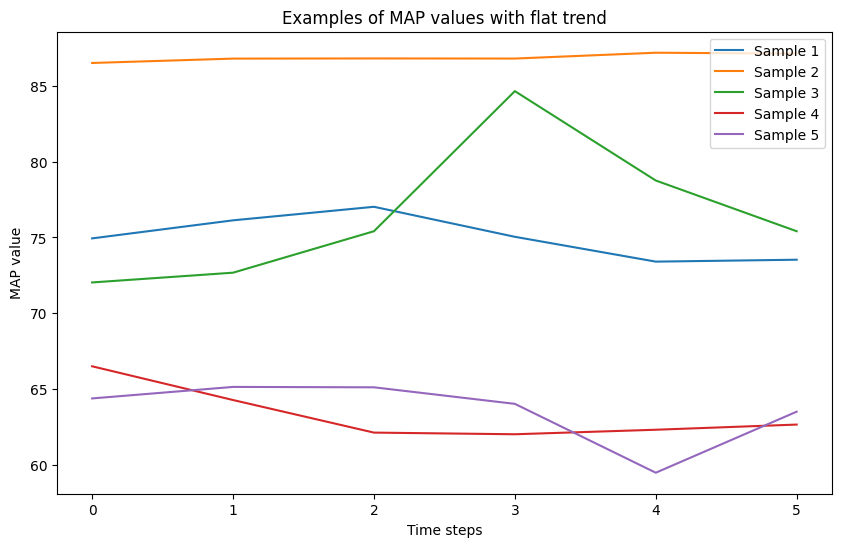

Number of samples with downward trend: 644
Number of samples with flat trend: 2671
Number of samples with upward trend: 561
Percentage of samples with flat trend: 0.69%
subsample_rate 0.45114189442156494
Shape of subsampled data: torch.Size([1205, 12, 13])


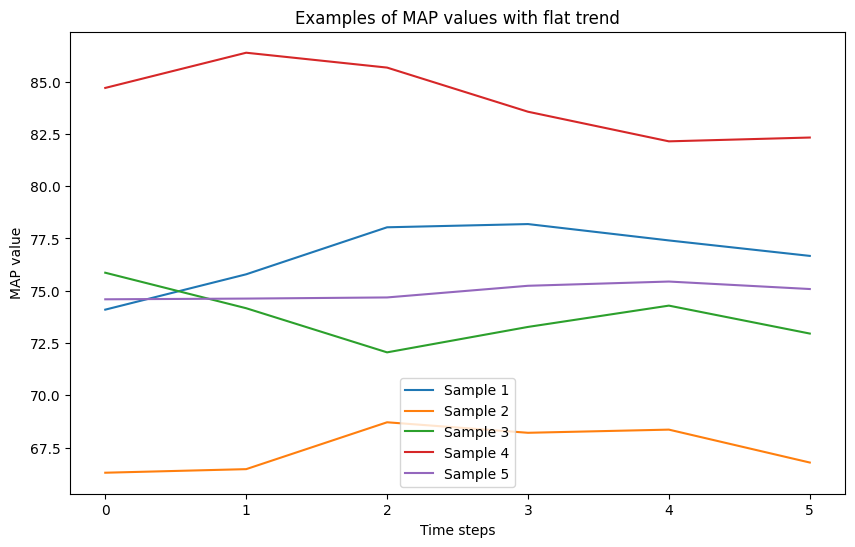

Number of samples with downward trend: 315
Number of samples with flat trend: 1344
Number of samples with upward trend: 279
Percentage of samples with flat trend: 0.69%
subsample_rate 0.4419642857142857
Shape of subsampled data: torch.Size([594, 12, 13])


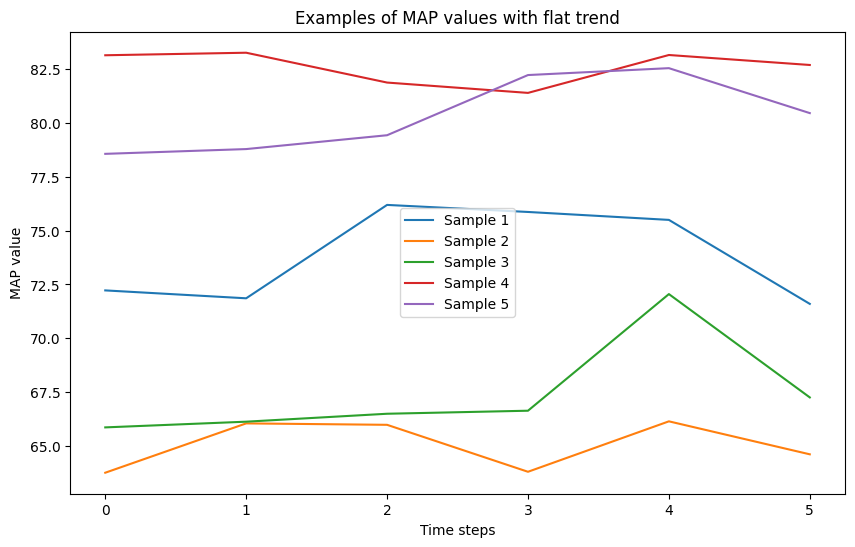

In [15]:
with open('/abiomed/downsampled/10min_1hr_all_data.pkl', 'rb') as f:
    data = pickle.load(f)

data_train = data['train']
data_test = data['test']
data_val = data['val']
mean = data['mean']
std = data['std']


new_train = analyze_trends(data_train)
new_test = analyze_trends(data_test)
new_val = analyze_trends(data_val)

mean = torch.mean(new_train.reshape(-1, 13), axis=0)
std = torch.std(new_train.reshape(-1, 13), axis=0)

with open('/abiomed/downsampled/10min_1hr_all_data_subsampled.pkl', 'wb') as f:
    pickle.dump({'train': new_train, 'val': new_val, 'test': new_test, 
    'mean': mean, 'std': std}, f)




(array([1886.,    0.,    0.,    0.,    0., 8486.,    0.,    0.,    0.,
        1679.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

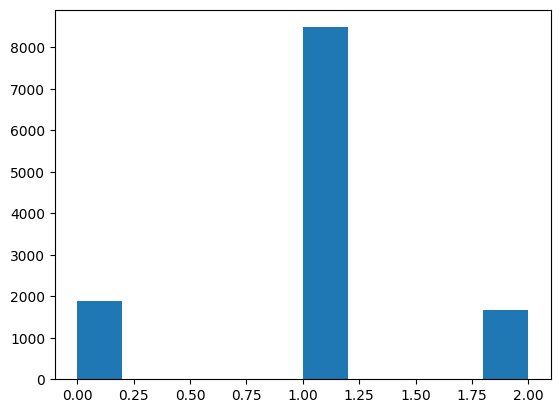

In [13]:
plt.hist(target_trends)

In [30]:

print(np.mean(rewards), np.std(rewards))

-8.929224 4.4131603


In [18]:

import sys
sys.path.append("..")
from data_utils import load_and_normalize_data, create_datasets
from baselines import MLPDropoutBaseline, NeuralProcessBaseline, CLMUBaseline, StateSpaceBaseline
from evaluation_metrics import unnormalize_predictions
from model import WorldModel

with open('/abiomed/downsampled/10min_1hr_all_data.pkl', 'rb') as f:
    data = pickle.load(f)

data_train = data['train']
data_test = data['test']
data_val = data['val']
mean = data['mean']
std = data['std']

In [8]:
data_train.shape

torch.Size([12051, 12, 13])

In [ ]:
all_hours = data_train.reshape(-1, 6, 13)

all_hours.shape

torch.Size([24102, 6, 13])

In [18]:
sys.path.append("../..")
from reward_func import compute_reward_smooth
from tqdm  import tqdm

rewards_pred = []
for pred in tqdm(all_hours):
    rew = (compute_reward_smooth(pred) + 8.929224)/4.4131603
    rew = np.clip(rew, -2, 2)
    rewards_pred.append(rew)

print(np.mean(rewards_pred))


100%|██████████| 24102/24102 [00:08<00:00, 2932.42it/s]


-0.02987071


In [19]:
np.mean(rewards_pred)

np.float32(-0.02987071)

In [20]:
from tqdm import tqdm
all_data = torch.cat([data_train, data_val, data_test])
all_data_all_hours = all_data.reshape(-1, 6, 13)

print(all_data_all_hours.shape)


rewards_pred = []
for pred in tqdm(all_data_all_hours):
    rew = (compute_reward_smooth(pred) + 8.93)/4.41
    rew = np.clip(rew, -2, 2)
    rewards_pred.append(rew)

print(np.mean(rewards_pred))


torch.Size([35730, 6, 13])


100%|██████████| 35730/35730 [00:12<00:00, 2903.12it/s]


0.0055152676


In [19]:
transformer = WorldModel(
            num_features=12,
            dim_model=256,
            num_heads=8,
            num_encoder_layers=3,
            num_decoder_layers=2,
            encoder_dropout=0.1,
            decoder_dropout=0.0,
            max_len=100,
            forecast_horizon=6,
            model_type='transformer',
            device='cuda:1'
        )

transformer.load_model('/abiomed/downsampled/models/10min_1hr_all_data_model.pth')

time series transformer device cuda:1
Using device: cuda:1


/home/ubuntu/miniconda3/envs/py310/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/ubuntu/abiomed/noisy_mujoco/abiomed_env/data_proc/../model.py:410: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user vi

In [20]:
from data_utils import load_and_normalize_data, create_datasets

device = 'cuda:1'
data_path = '/abiomed/downsampled/10min_1hr_all_data.pkl'
normalized_data = load_and_normalize_data(data_path, drop_col_11=True)

train_dataset, val_dataset, test_dataset = create_datasets(
    normalized_data, input_horizon=6, output_horizon=6
)

data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
predictions = []
targets_all = []
with torch.no_grad():
    for i, (inputs, pl, targets) in enumerate(data_loader):
        
        inputs = inputs.to(device)
        pl = pl.to(device)
        targets = targets.to('cpu')
        pred = transformer(inputs, pl)
        pred = pred.detach().cpu()

        pred_unnorm, target_unnorm = unnormalize_predictions(
            pred, targets, mean, std, 6
        )
        predictions.append(pred_unnorm)
        targets_all.append(target_unnorm)





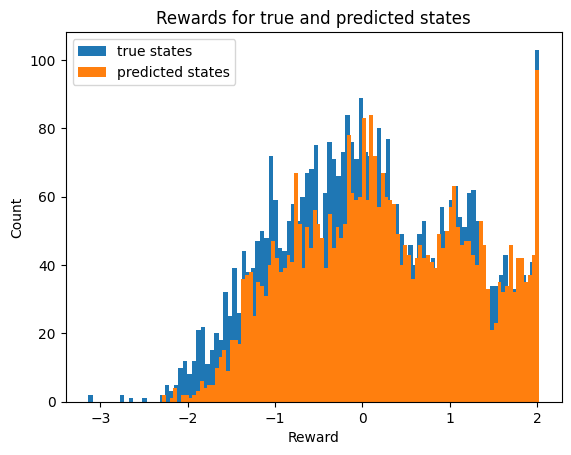

In [23]:
sys.path.append("../..")
from reward_func import compute_reward_smooth

rewards_pred = []
for pred in predictions:
    rewards_pred.append((compute_reward_smooth(pred) + 8.929224)/4.4131603)

rewards_target = []
for pred in targets_all:
    rewards_target.append((compute_reward_smooth(pred) + 8.929224)/4.4131603)

plt.hist(rewards_target, bins=100, label='true states')
plt.hist(rewards_pred, bins=100, label='predicted states')
plt.title("Rewards for true and predicted states")
plt.xlabel("Reward")
plt.ylabel("Count")
plt.legend()
plt.show()


In [26]:
np.mean(rewards_pred), np.mean(rewards_target)

(np.float32(0.24308217), np.float32(0.08279501))

In [2]:
gamma = 0.99
mult = 1
rew = 0

for i in range(24):
    rew += mult * .0827
    mult = mult * gamma

rew

1.7724417755242987

In [6]:
train.shape

NameError: name 'train' is not defined

In [ ]:
# 1325 patients in total
# 896 greater than 1 hour
# 640 greater than 2 hour
# 357 greater than 5 hour
# 87 greater than 24 hour
